# ENSF 544 Data Science for Software Engineers
## Phase 1
#### By: Kyle Friedt, Erslan Salman, Kelvin Tran and Avneet Gill

### Scrape and Clean data from Zomato Website

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re

# returns array of addresses and postal codes of restuarants 
def get_addresses(url):
    addresses = []
    postalcodes = []
    
    zomato_html = get_page_html(url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    address_tag = parser.find_all("div", class_ = "col-m-16 search-result-address grey-text nowrap ln22")
    
    for address in address_tag:
        postal = None
        temp  = address.get_text()
        temp = temp.strip("\n")
        temp = temp.strip()
        
        #looks for 6 digit postal code in Canadian format
        if re.search('[A-Za-z]\d[A-Za-z][ -]?\d[A-Za-z]\d$',temp) != None:
            postal = re.findall('[A-Za-z]\d[A-Za-z][ -]?\d[A-Za-z]\d$',temp)[0]
            temp = temp.replace(postal,"")
            postal = postal.replace(" ","")
            postal = postal.replace("-","")
            
        #looks for 3 digit postal code and removes it
        elif re.search('[A-Za-z]\d[A-Za-z]$',temp) != None:
            postal = re.findall('[A-Za-z]\d[A-Za-z]',temp)[0]
            temp = temp.replace(postal,"")
            
        addresses.append(temp)
        postalcodes.append(postal)
 
    return addresses, postalcodes

In [4]:
# gets all resturant titles in a page of resturants given its url 
def get_titles(url):
    titles = []

    zomato_html = get_page_html(url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    title_tag = parser.find_all("a", class_ = "result-title" )
    
    for title in title_tag:
        temp  = title.get_text()
        temp = temp.strip("\n")
        temp = temp.strip()
        titles.append(temp)
    
    return titles


In [5]:
# gets the average rating and the number of ratings for each restaurant on the page
def get_rating(page_url):
    zomato_html = get_page_html(page_url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    rows = parser.find_all("div", class_="search-snippet-card")
    rating_list = []
    num_rating_list = []
    for row in rows:
        rating = row.find("span", class_="rating-value")
        if rating is not None:
            rating = float(rating.text)
        num_ratings = row.find("span", class_="review-count")
        if num_ratings is not None:
            num_ratings = int(re.search("([0-9]*)",num_ratings.text.strip().replace(',','').replace("(",'')).group(1))
        rating_list.append(rating)
        num_rating_list.append(num_ratings)
    
    return rating_list, num_rating_list

In [6]:
# gets an array of cuisine types for each restaurant on the page
def get_cuisines(page_url):
    zomato_html = get_page_html(page_url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    rows = parser.find_all("div", class_="search-snippet-card")
    cuisine_list = []
    
    for row in rows:
        cuisines = []
        cuisine_tag = row.find("span", text = "Cuisines: ")
        #print(cuisine_tag)
        #print('test')
        if cuisine_tag is not None:
            for cuisine in cuisine_tag.parent.find_all('a'):
                #print(cuisine.text)
                #print('test')
                cuisines.append(cuisine.text)
                
        cuisine_list.append(cuisines)
        #print(cuisine_list)
        #print('test')
    return cuisine_list

In [7]:
#gets the url for the next page of resturant lists
def get_next_page(parser):
    links_array = []
    
    next_page = parser.find("a", class_="paginator_item next item")
    next_page = "https://www.zomato.com" + str(next_page['href'])
    next_page = next_page.split("=")
    stripped = next_page[0]
    return stripped
# returns how many pages of resturants there are total
def get_number_of_pages(parser):
    next_page = parser.find("div", class_="col-l-4 mtop pagination-number")
    next_page = next_page.find_all('b')
    number = next_page[1].get_text()
    return number 
#returns an array of all resturant page urls
def get_all_links(url,number):
    links = []
    links.append(url)
    url_ = url + "="
    
    for x in range(2,int(number)+1):
        new_link = url_+str(x)
        links.append(new_link)
        
    return links
    
def get_page_html(url):    
    headers = {"User-Agent":"Mozilla/5.0"}
    source=requests.get(url, headers=headers).text
    return source

In [8]:

# gets all resturant data in a given city
def get_resturant_data(parser):
    url = get_next_page(parser)
    number = get_number_of_pages(parser)
    links = get_all_links(url, number)
    titles = []
    addresses = []
    postal_codes = []
    ratings = []
    num_ratings = []
    cuisines = []
    
    for link in links:
        title = get_titles(link)
        titles = titles + title
        
        address, postal = get_addresses(link)
        addresses.extend(address)
        postal_codes.extend(postal)
        
        rating,num_rating = get_rating(link)
        ratings.extend(rating)
        num_ratings.extend(num_rating)
        
        cuisine = get_cuisines(link)
        cuisines.extend(cuisine)
               
        print("loading...")
    
    df = pd.DataFrame(titles, columns = ['name'])
    df['address'] = addresses
    df['postal_code'] = postal_codes
    df['rating'] = ratings
    df['num_ratings'] = num_ratings
    df['cuisines'] = cuisines
    return df



In [17]:
# Used for cleaning the city name in the Zomato data and the Yelp data. 
def clean_name(x):
    x = re.sub('&', 'and', x)
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    return x

def clean_name_column(df):
    df.name = df.name.apply(clean_name)
    return df

In [10]:
#CALGARY
calgary_url = "https://www.zomato.com/calgary/restaurants"
calgary_html = get_page_html(calgary_url)
calgary_parser = BeautifulSoup(calgary_html, 'html.parser')

calgary_df = get_resturant_data(calgary_parser)
calgary_df = clean_name_column(calgary_df)
calgary_df.head()

#TORONTO
toronto_url = "https://www.zomato.com/toronto/restaurants"
toronto_html = get_page_html(toronto_url)
toronto_parser = BeautifulSoup(toronto_html, 'html.parser')

toronto_df = get_resturant_data(toronto_parser)
toronto_df = clean_name_column(toronto_df)

#MONTREAL
montreal_url = "https://www.zomato.com/montreal/restaurants"
montreal_html = get_page_html(montreal_url)
montreal_parser = BeautifulSoup(montreal_html, 'html.parser')

montreal_df = get_resturant_data(montreal_parser)
montreal_df = clean_name_column(montreal_df)

loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...


,name,address,postal_code,rating,num_ratings,cuisines
0,oeb breakfast co,"825 1 Ave NE, Bridgeland, Calgary",T2E3J6,4.9,1463,"[American, Diner]"
1,una pizza and wine,"618 17 Avenue SW, Calgary",T2S0B4,4.6,1708,"[Italian, Pizza]"
2,notable,"4611 Bowness Rd NW, Calgary",T3B0S4,4.4,1297,[Canadian]
3,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464,"[European, French, Tapas]"
4,blue star diner,"809 1 Ave NE, Calgary",T2E0C1,4.6,967,"[Breakfast, Burger]"
...,...,...,...,...,...,...
145,pigeonhole,"306 17th Ave SW, Calgary",T2S0A8,3.8,123,"[Tapas, Bar Food]"
146,1410 bier haus,"1410 17 Ave SW, Calgary",T2T0C3,4.1,424,[Bar Food]
147,grumans catering and delicatessen,"230 - 11 Avenue SE, Calgary",T2G0X8,4.2,230,"[Deli, American]"
148,smashburger,2790 32nd Avenue Ne,T1Y5S5,4.2,386,[Burger]


### Run this to generate CSV from Zomato DFs

In [11]:
# scraping the websites takes a long time so we created csv files of our dataframes
calgary_df.to_csv("calgary.csv",index = False)
toronto_df.to_csv("toronto.csv",index = False)
montreal_df.to_csv("montreal.csv",index = False)

### Reload dataframes from zomato CSV files

In [4]:
import pandas as pd

# function to generate data frame with cuisines as list
def df_from_csv(fname):
    df = pd.read_csv(fname)
    # set cusine values as list from string
    df['cuisines'] = df['cuisines'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))
    return df


#CALGARY
calgary_df = df_from_csv("calgary.csv")
calgary_df.head()

,name,address,postal_code,rating,num_ratings,cuisines
0,oeb breakfast co,"825 1 Ave NE, Bridgeland, Calgary",T2E3J6,4.9,1463.0,"[American, Diner]"
1,una pizza and wine,"618 17 Avenue SW, Calgary",T2S0B4,4.6,1708.0,"[Italian, Pizza]"
2,notable,"4611 Bowness Rd NW, Calgary",T3B0S4,4.4,1297.0,[Canadian]
3,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464.0,"[European, French, Tapas]"
4,blue star diner,"809 1 Ave NE, Calgary",T2E0C1,4.6,967.0,"[Breakfast, Burger]"


In [8]:
#TORONTO
toronto_df = df_from_csv("toronto.csv")
toronto_df.head()

,name,address,postal_code,rating,num_ratings,cuisines
0,auberge du pommier,"4150 Yonge St., Toronto, ON",M2P2C6,4.5,644.0,[French]
1,terroni,"57A Adelaide Street East, Toronto",NaN,4.0,564.0,"[Italian, Pizza]"
2,kinka izakaya,"398 Church Street, Toronto M5B 2A2 2A2",NaN,4.6,1166.0,"[Japanese, Asian]"
3,pai,"18 Duncan Street, Toronto",NaN,4.9,614.0,"[Thai, Asian]"
4,banh mi boys,"392 Queen Street West, Toronto",NaN,4.7,941.0,[Sandwich]


In [9]:
#MONTREAL 
montreal_df = df_from_csv("montreal.csv")
montreal_df.head()

,name,address,postal_code,rating,num_ratings,cuisines
0,kazu,"1862 Rue Ste-Catherine O, Montreal",H3H1M2,4.8,1277.0,"[Asian, BBQ, Japanese]"
1,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian]"
2,olive et gourmando,"351 Rue St-Paul O, Montreal",H2Y2A7,4.7,892.0,"[Cafe, Bakery]"
3,schwartzs montreal hebrew delicatessen,"3895 Boulevard Saint-Laurent, Montreal",H2W1L2,4.4,2113.0,"[Eastern European, Deli]"
4,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian]"


### Process Yelp Json and Clean Data

In [10]:
# open the json file
def get_yelp_json():
    path = 'business.json'
    df = pd.read_json(path, lines=True)
    print(df.shape)
    return df    

In [11]:
# initial cleaning get businesses that are open, in Calgary, and have > 2 stars
# also get relevent columns

def initial_yelp_clean(df, city_name):
    df = df[df.is_open == 1]
    df = df[df.city.str.contains(city_name)]
    df = df.loc[:, ('name', 'city', 'address', 'postal_code', 'stars', 
                    'review_count', 'categories')]# .copy()
    df['city'] = city_name
    df = df[df.stars > 2]
    print(df.shape)
    return df

In [12]:
# get rid of businesses with empty categories
# get rid of businesses without postal code (using postal code for merge)
def drop_yelp_nan(df):
    df['categories'].replace('', np.nan, inplace=True)
    df['postal_code'].replace('', np.nan, inplace=True)
    df = df.dropna()
    print(df.shape)
    return df

In [13]:
# Get businesses that only have Restaurant or Food as a category
def get_restaurants(df):
    tags = ['Restaurants', 'Food']
    mask = df.categories.apply(lambda x: any(item for item in tags if item in x))
    df = df[mask]
    print(df.shape)
    return df

In [14]:
# Exclude rows that have category tags that we don't want
def drop_tags(df):
    tags = ['Gas Stations', 'Convenience Stores', 'Grocery', 'Gyms', 
            'Hunting & Fishing Supplies']
    mask = df.categories.apply(lambda x: not any(item for item in tags if item in x))
    df = df[mask]
    print(df.shape)
    return df

In [15]:
# Get rid of businesses that have the name Liqour in it
def drop_liquor(df):
    df = df[~df['name'].str.contains('Liquor')]
    print(df.shape)
    return df

In [16]:
def clean_postal(x):
    if len(x) < 4:
        x = np.nan
    else:
        x = re.sub(' ', '', x)
    return x

def clean_postal_code(df):
    df.postal_code = df.postal_code.apply(clean_postal)
    return df

In [12]:
# def clean_name(x):
#     x = re.sub('&', 'and', x)
#     x = x.lower()
#     x = re.sub(r'[^\w\s]', '', x)
#     return x

# def clean_name_column(df):
#     df.name = df.name.apply(clean_name)
#     return df

In [19]:
import pandas as pd
import numpy as np
import re
# function calls to get json data and generate a clean dataframe

def generate_yelp_df(city_name):
    # generate dataframe with necessary columns
    yelp_df = get_yelp_json()
    yelp_df = initial_yelp_clean(yelp_df, city_name)
    yelp_df = drop_yelp_nan(yelp_df)

    # clean the data to exclude businesses that are not restaurants
    yelp_df = get_restaurants(yelp_df)
    yelp_df = drop_tags(yelp_df)
    yelp_df = drop_liquor(yelp_df)
    yelp_df = clean_postal_code(yelp_df)
    # call to function from the Zomato Section
    yelp_df = clean_name_column(yelp_df)
    yelp_df.to_csv('yelp.csv')
    return yelp_df

# generate the data frames for necessary cities

#CALGARY
yelp_calgary_df = generate_yelp_df('Calgary')
yelp_calgary_df.head()

(209393, 14)
(5726, 7)
(5679, 7)
(2656, 7)
(2480, 7)
(2453, 7)


,name,city,address,postal_code,stars,review_count,categories
322,singapore sams,Calgary,555 11 Avenue SW,T2R1P6,3.5,37,"Chinese, Restaurants, Buffets"
378,otto gelato,Calgary,400-5 Avenue SW,T2P0L6,5.0,13,"Ice Cream & Frozen Yogurt, Food, Coffee & Tea"
603,asian buffet,Calgary,"9125 Bonaventure Dr SE, Unit 23",T2J0P5,2.5,36,"Restaurants, Asian Fusion"
627,rickys all day grill,Calgary,"8180 11 Street SE, Unit 860",T2H3B5,3.0,11,"Food, Restaurants, Breakfast & Brunch"
763,mucho burrito,Calgary,2312 4th Street SW,T2S1W9,3.5,17,"Restaurants, Mexican"


In [20]:
#TORONTO
yelp_toronto_df = generate_yelp_df('Toronto')
yelp_toronto_df.head()

(209393, 14)
(13051, 7)
(12973, 7)
(6589, 7)
(6249, 7)
(6248, 7)


,name,city,address,postal_code,stars,review_count,categories
73,mi mi restaurant,Toronto,688 Gerrard Street E,M4M1Y3,4.0,116,"Vietnamese, Restaurants"
110,tim hortons,Toronto,90 Adelaide Street W,M5H3V9,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res..."
111,gigbites internet cafe,Toronto,618 Bloor St W,NaN,3.0,4,"Home Services, Shopping, IT Services & Compute..."
149,chicknjoy,Toronto,3-1265 York Mills Road,M3A1Z3,3.0,11,"Fast Food, Restaurants, Chicken Shop"
150,zav coffee shop and gallery,Toronto,2048 Danforth Avenue,M4C1J6,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food"


In [21]:
#MONTREAL
#changed so that it has a more generic search, names have accent over the 'e'
yelp_montreal_df = generate_yelp_df('Montr')
yelp_montreal_df.head()

(209393, 14)
(5181, 7)
(5152, 7)
(3476, 7)
(3314, 7)
(3314, 7)


,name,city,address,postal_code,stars,review_count,categories
43,amir,Montr,5252 Rue Jean Talon O,H4P2A7,3.0,18,"Restaurants, Lebanese, Middle Eastern"
45,starbucks,Montr,150 Boulevard Crémazie E,H2P1E2,3.5,4,"Coffee & Tea, Food"
97,caballero,Montr,804www.caballerolounge.com Rue Roy E,H2L1E3,3.5,3,"Restaurants, Tapas/Small Plates"
218,cari mela,Montr,2556 Rue Centre,H3K1J8,3.5,9,"Indian, Restaurants"
339,b montréal,Montr,1207-A Rue Rachel E,H2J2J8,4.5,3,"Coffee & Tea, Food, Juice Bars & Smoothies, De..."


### Merge the Dataframes from Zomato and Yelp


In [22]:
def merge_dframes(df1, df2):
    # merge the city dataframes based on the restaurant name and postal code
    df = df1.merge(df2, how = "inner", left_on = ["name","postal_code"],right_on = ["name","postal_code"])
    return df

#yelp and zomato data merged dataframe for calgary
merged_calgary = merge_dframes(calgary_df, yelp_calgary_df)
merged_calgary.head()

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464.0,"[European, French, Tapas]",Calgary,101-899 Centre Street S,4.0,328,"Restaurants, Steakhouses"
1,the himalayan,3218 17th Avenue SW,T3E0B3,4.9,748.0,"[Asian, Indian]",Calgary,3218 17 Avenue SW,4.5,234,"Restaurants, Himalayan/Nepalese"
2,the coup,"924 17 Avenue SW, Calgary",T2T0A2,4.6,1113.0,"[Vegetarian, Desserts]",Calgary,924 17th Avenue SW,4.0,235,"Cocktail Bars, Vegetarian, Restaurants, Bars, ..."
3,pfanntastic pannenkoek haus,"2439 54 Ave SW, Calgary",T3E1M4,4.7,940.0,[Cafe],Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126,"Restaurants, Breakfast & Brunch, Scandinavian"
4,model milk,"308 17 Ave SW, Calgary",T2S0A3,4.2,832.0,"[Seafood, Tapas, Fusion]",Calgary,308 17th Avenue,4.0,234,"American (New), Restaurants, Food, Canadian (New)"


In [23]:
#yelp and zomato data merged dataframe for toronto
merged_toronto = merge_dframes(toronto_df, yelp_toronto_df)
merged_toronto.head()

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,auberge du pommier,"4150 Yonge St., Toronto, ON",M2P2C6,4.5,644.0,[French],Toronto,4150 Yonge Street,4.0,343,"French, Restaurants"
1,banh mi boys,"392 Queen Street West, Toronto",NaN,4.7,941.0,[Sandwich],Toronto,399 Yonge Street,4.0,483,"Vietnamese, Asian Fusion, Restaurants"
2,pizzeria libretto,"221 Ossington Avenue, Toronto",M6J2Z8,4.5,1011.0,"[Pizza, Italian]",Toronto,221 Ossington Avenue,4.0,538,"Pizza, Italian, Restaurants"
3,the stockyards,"699 St Clair Avenue West, Toronto",M6C1B2,4.6,735.0,"[BBQ, Burger]",Toronto,699 St. Clair Avenue W,4.0,718,"American (Traditional), Restaurants, Barbeque,..."
4,richmond station,"1 Richmond Street West, Suite 120, Toronto",M5H3W4,4.8,490.0,"[Italian, Canadian]",Toronto,1 Richmond Street W,4.5,751,"Restaurants, Canadian (New)"


In [24]:
#yelp and zomato data merged dataframe for montreal
merged_montreal = merge_dframes(montreal_df, yelp_montreal_df)
merged_montreal.head()

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian]",Montr,536 Avenue Duluth E,4.0,1273,"French, Canadian (New), Restaurants, American ..."
1,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian]",Montr,994 Rue Rachel E,4.0,1945,"Fast Food, Diners, Restaurants, Poutineries"
2,cacao 70,"2087 Ste. Catherine West, Montreal",H3H1M6,4.3,711.0,"[Breakfast, Desserts, Crepes]",Montr,2087 Rue Saint-Catherine,4.0,272,"Specialty Food, Desserts, Chocolatiers & Shops..."
3,leméac,"1045 Ave Laurier W, Montréal",H2V2L1,4.5,719.0,[French],Montr,1045 Avenue Laurier O,4.5,250,"French, Restaurants"
4,deville dinerbar,"1425 Rue Stanley, Montreal",H3A1P4,4.3,556.0,[Diner],Montr,1425 Rue Stanley,4.0,546,"American (Traditional), American (New), Diners..."


### Realised that there were numerous versions of the City Montreal including special characters. 
### Further cleaning was required. 

In [25]:
# clean the montreal city name, get all names to say 'Montreal'
def clean_city(x):
    x = x.lower()
    if x.find('mont') != -1:
        return 'Montreal'
    else:
        return x
    

def clean_montreal(df):
    df.city = df.city.apply(clean_city)
    return df

merged_montreal = clean_montreal(merged_montreal)
merged_montreal.head()

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian]",Montreal,536 Avenue Duluth E,4.0,1273,"French, Canadian (New), Restaurants, American ..."
1,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian]",Montreal,994 Rue Rachel E,4.0,1945,"Fast Food, Diners, Restaurants, Poutineries"
2,cacao 70,"2087 Ste. Catherine West, Montreal",H3H1M6,4.3,711.0,"[Breakfast, Desserts, Crepes]",Montreal,2087 Rue Saint-Catherine,4.0,272,"Specialty Food, Desserts, Chocolatiers & Shops..."
3,leméac,"1045 Ave Laurier W, Montréal",H2V2L1,4.5,719.0,[French],Montreal,1045 Avenue Laurier O,4.5,250,"French, Restaurants"
4,deville dinerbar,"1425 Rue Stanley, Montreal",H3A1P4,4.3,556.0,[Diner],Montreal,1425 Rue Stanley,4.0,546,"American (Traditional), American (New), Diners..."


In [29]:
# used to remove duplicates in the cusine types
def remove_duplicates(x):
  return list(dict.fromkeys(x))


In [27]:
# created a dictionary to put exceptions for dictionary matches. 
def cuisine_exceptions(c):
    exceptions = {
        'Afghan':'Afghani',
        'Tapas':'Tapas/Small Plates',
        'Brasserie':'Brasseries',
        'Breakfast':'Breakfast & Brunch',
        'Burger':'Burgers',
        'Cafe':'Cafes',
        'Creperies':'Crepes',
        'Deli':'Delis',
        'Diner':'Diners',
        'Hotel':None,
        'Hotels & Travel':None,
        'Ice Cream':'Ice Cream & Frozen Yogurt',
        'Juices':'Juice Bars & Smoothies',
        'Patisserie':'Patisserie/Cake Shop',
        'Salvadoran':'Salvadorean',
        'Sandwich':'Sandwiches',
        'Restaurants':None,
        'Airport Lounges':None,
        'Art Classes':None,
        'Art Galleries':None,
        'Art Schools':None,
        'Arts & Crafts':None,
        'Arts & Entertainment':None,
        'Beauty & Spas':None,
        'Beer Bar':'Beer',
        'Beer Gardens':'Beer',
        'Beer Tours':'Beer',
        'Books':None,
        'Bookstores':None,
        'Bowling':None,
        'Comedy Clubs':None,
        'Comic Books':None,
        'Cooking Classes':None,
        'Cooking Schools':None,
        'Custom Cakes':'Patisserie/Cake Shop',
        'Dance Clubs':None,
        'Department Stores':None,
        'Dinner Theater':None,
        'Do-It-Yourself Food':None,
        'Education':None,
        'Escape Games':None,
        'Event Planning & Services':None,
        'Eyelash Service':None,
        'Fashion':None,
        'Flowers & Gifts':None,
        'Food':None,
        'Food Court':None,
        'Food Delivery Services':None,
        'Food Stands':None,
        'Food Trucks':None,
        'Gay Bars':None,
        'Gift Shops':None,
        'Hookah Bars':None,
        'Internet Cafes':None,
        'Irish Pub':'Irish',
        'Jazz & Blues':None,
        'Karaoke':None,
        'Lounges':None,
        'Music & Video':None,
        'Music Venues':None,
        'Nail Salons':None,
        'Nightlife':None,
        'Nurseries & Gardening':None,
        'Party & Event Planning':None,
        'Pet Groomers':None,
        'Pet Services':None,
        'Pets':None,
        'Pool Halls':None,
        'Religious Organizations':None,
        'Shopping':None,
        'Skin Care':None,
        'Social Clubs':None,
        'Specialty Schools':None,
        'Sports Bars':None,
        'Stadiums & Arenas':None,
        'Street Vendors':None,
        'Tabletop Games':None,
        'Sushi Bars':'Sushi',
        'Tattoo':None,
        'Themed Cafes':None,
        'Tours':None,
        'Toy Stores':None,
        'Venues & Event Spaces':None,
        'Vinyl Records':None,
    }
    
    if c in exceptions: 
        return exceptions[c] 
    else: 
        return c

In [30]:
#create a dataframe that has all of the merged dataframes, contains data from yelp and zomato for Calgary, Toronto and Montreal
final_df = merged_calgary.append(merged_montreal).append(merged_toronto)

#removing duplicate columns
final_df = final_df.drop('address_x',1)

#combine categories and cuisines
cuisines = final_df['cuisines'].tolist()
categories = final_df['categories'].tolist()
combined = []

# generate a combined list of the categories from the two sites.
for cuisine,category in zip(cuisines,categories):
    category = category.strip()
    category = category.strip(',')
    category = category.split(',')
    for index, c in enumerate(category):
        c = c.strip(", ")
        c = c.replace('(New)','')
        c = c.replace('(Traditional)','')
        c = c.replace(' and ',' & ')
        c = c.strip()
        category[index] = cuisine_exceptions(c)
        
    for index, c in enumerate(cuisine):
        if c is not None:
            c = c.strip(", ")
            c = c.replace('(New)','')
            c = c.replace('(Traditional)','')
            c = c.replace(' and ',' & ')
            c = c.strip()
        cuisine[index] = cuisine_exceptions(c)       
    
    cuisine.extend(category)
    cuisine = remove_duplicates(cuisine)
    cuisine = list(filter(lambda x:(x is not None) & (x !=''), cuisine))
    combined.append(cuisine)
    
# assign the combined list to cuisines    
final_df['cuisines'] = combined
# drop the categories column, no longer needed
final_df= final_df.drop('categories',1)
final_df.head()

,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count
0,charcut roast house,T2G1B8,4.4,1464.0,"[European, French, Tapas/Small Plates, Steakho...",Calgary,101-899 Centre Street S,4.0,328
1,the himalayan,T3E0B3,4.9,748.0,"[Asian, Indian, Himalayan/Nepalese]",Calgary,3218 17 Avenue SW,4.5,234
2,the coup,T2T0A2,4.6,1113.0,"[Vegetarian, Desserts, Cocktail Bars, Bars, Br...",Calgary,924 17th Avenue SW,4.0,235
3,pfanntastic pannenkoek haus,T3E1M4,4.7,940.0,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126
4,model milk,T2S0A3,4.2,832.0,"[Seafood, Tapas/Small Plates, Fusion, American...",Calgary,308 17th Avenue,4.0,234


### We have separate ratings from each of the sites. We used this function to create a weighted rating. 
### The weight was based on the number of ratings from each site. 

In [33]:
# get weighted ratings
def weighted_avg_rating(df):
    # get the total number of ratings
    df['total_ratings'] = df[['num_ratings', 'review_count']].sum(axis=1) 
    
    # get weight for the review from each site    
    df['yelp_wt'] = df.apply(lambda x: x.review_count/x.total_ratings if x.review_count > 0 else 0, axis=1)
    df['zomato_wt'] = df.apply(lambda x: x.num_ratings/x.total_ratings if x.num_ratings > 0 else 0, axis=1)
    
    # calculate each sites weighted rating
    df['y_wt_rate'] = df.apply(lambda x: x.yelp_wt * x.stars if x.yelp_wt > 0 else 0, axis=1)
    df['z_wt_rate'] = df.apply(lambda x: x.zomato_wt * x.rating if x.zomato_wt > 0 else 0, axis=1)

    # calculate the overall avg rating
    df['overall_rating'] = df.z_wt_rate + df.y_wt_rate
    return df


final_df = weighted_avg_rating(final_df)
final_df = final_df.drop(['num_ratings','review_count','rating','stars','yelp_wt','zomato_wt','y_wt_rate','z_wt_rate'],1)
final_df.head()

,name,postal_code,cuisines,city,address_y,total_ratings,overall_rating
0,charcut roast house,T2G1B8,"[European, French, Tapas/Small Plates, Steakho...",Calgary,101-899 Centre Street S,1792.0,4.326786
1,the himalayan,T3E0B3,"[Asian, Indian, Himalayan/Nepalese]",Calgary,3218 17 Avenue SW,982.0,4.804684
2,the coup,T2T0A2,"[Vegetarian, Desserts, Cocktail Bars, Bars, Br...",Calgary,924 17th Avenue SW,1348.0,4.495401
3,pfanntastic pannenkoek haus,T3E1M4,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",1066.0,4.676360
4,model milk,T2S0A3,"[Seafood, Tapas/Small Plates, Fusion, American...",Calgary,308 17th Avenue,1066.0,4.156098


## Analysis of Data
### Q1.1 : Is there a highest rated cuisine?

In [41]:
# data investigation before getting highest rated cuisine
exp_cuisine_df = final_df.explode('cuisines')
# tell us what cuisine types we could potentially exclude. 
exp_cuisine_df.cuisines.value_counts()[:20]

Coffee & Tea          632
Cafes                 578
Bars                  373
Donuts                324
Canadian              277
Breakfast & Brunch    255
Sandwiches            241
Desserts              220
American              214
Italian               202
Japanese              192
Fast Food             190
Pizza                 187
Chinese               171
Asian                 159
Burgers               156
Bar Food              152
Bakeries              149
Sushi                 145
Specialty Food        126
Name: cuisines, dtype: int64

In [25]:
# function to get the counts and means with counts > 24
def cuisine_count_mean(df):
    df = df.groupby('cuisines')['overall_rating'].aggregate(['count', np.mean])
    # only look at cusine types with counts above 24
    df = df[df['count'] >= 25]
    # look at top rated restaurants
    df = df.sort_values(by=['mean'], ascending=False)
    return df

cuisine_stats_df = cuisine_count_mean(exp_cuisine_df)
cuisine_stats_df.head(10)

,count,mean
cuisines,,
Wine Bars,68,4.015222
Tapas/Small Plates,64,3.989327
Vegan,50,3.948878
French,120,3.931251
Bakery,91,3.896570
Bakeries,149,3.889701
Fusion,32,3.882412
Steak,36,3.876497
Juice Bars & Smoothies,50,3.866926


In [26]:
# look at individual cities. 
ca_df = df_exp[df_exp.city == 'Calgary']
ca_df = cuisine_count_mean(ca_df)
ca_df.head()

,count,mean
cuisines,,
Desserts,27,3.981908
Bakeries,27,3.787210
Mediterranean,29,3.781105
Cafes,46,3.758878
Italian,36,3.754182


In [27]:
# Top 5 Cuisine types in Toronto
to_df = df_exp[df_exp.city == 'Toronto']
to_df = cuisine_count_mean(to_df)
to_df.head()

,count,mean
cuisines,,
Wine Bars,30,4.080669
Tapas/Small Plates,33,4.010142
Vegan,32,3.969712
French,44,3.961915
Healthy Food,25,3.957578


In [28]:
# Top 5 Cuisine types in Montreal
mo_df = df_exp[df_exp.city == 'Montreal']
mo_df = cuisine_count_mean(mo_df)
mo_df.head()

,count,mean
cuisines,,
Bakeries,28,4.154346
Desserts,37,4.070722
Cafes,69,4.022552
Coffee & Tea,66,4.002157
Vegetarian,26,3.949126


In [39]:
# import matplotlib.pyplot as plt
# def generate_top_cuisine_chart(df, city_name, num=5):
#     labels = df.index.values.tolist()[:num]
#     ratings = df['mean'].tolist()[:num]
#     plt.title(city_name)
#     plt.bar(labels, ratings)
 
    
# plt.figure(figsize=(20,4))
# plt.suptitle('Top 5 By City')
# plt.subplot(131)
# generate_top_cuisine_chart(ca_df, 'Calgary')
# plt.subplot(132)
# generate_top_cuisine_chart(to_df, 'Toronto')
# plt.subplot(133)
# generate_top_cuisine_chart(mo_df, 'Montreal')

In [40]:
# # All cities top 10
# plt.figure(figsize=(20,4))
# generate_top_cuisine_chart(all_df, 'All Cities', 10)

### Q1.2 : Is there a corelation between restaurant rating and cuisine type?

In [60]:
# get top rated restaurants in each city

def get_city_drop_sort_rating(df, name):
    df = df[df['city'] == name].copy()
    df = df.drop(['total_ratings','postal_code','address_y'],1)
    df = df.sort_values(by=['overall_rating'], ascending=False)
    
    return df

q1_calgary_df = get_city_drop_sort_rating(final_df, 'Calgary')
q1_toronto_df = get_city_drop_sort_rating(final_df, 'Toronto')
q1_montreal_df = get_city_drop_sort_rating(final_df, 'Montreal')
q1_calgary_df.head(10)

# get cuisine types for each restaurant


,name,cuisines,city,overall_rating,shortened_postal_codes
484,lindt chocolate shop,"[Desserts, Chocolatiers & Shops, Specialty Foo...",Calgary,5.000000,T2R
467,deville coffee,"[Cafes, Coffee & Tea, Coffee & Tea Supplies]",Calgary,5.000000,T3A
443,taste cafe,"[Cafes, Bakery, Coffee & Tea, Breakfast & Brun...",Calgary,5.000000,T2P
1,the himalayan,"[Asian, Indian, Himalayan/Nepalese]",Calgary,4.804684,T3E
420,raw eatery and market,"[Vegetarian, Vegan]",Calgary,4.759259,T2N
19,big catch sushi,"[Japanese, Sushi, Farmers Market]",Calgary,4.748630,T2V
10,vero bistro moderne,"[Breakfast & Brunch, Italian, Fusion, French]",Calgary,4.686640,T2N
3,pfanntastic pannenkoek haus,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,4.676360,T3E
355,village ice cream,"[Ice Cream & Frozen Yogurt, Desserts]",Calgary,4.600000,T2T
38,cactus club cafe,"[Steak, Fusion, Canadian, Cocktail Bars, Cafes...",Calgary,4.572894,T1Y


### Q2: Postal code areas with the highest rated restaurants in each city

In [57]:
#Add column with shortened postal code to final_df, just the first three digits for postal code areas
def generate_short_postalcode(df):
    postal_codes = df['postal_code'].tolist()
    shortened_codes = []
    
    for pc in postal_codes:
        if pc != np.nan:
            shortened_pc = str(pc)[:-3]
        else:
            shortened_pc = None
        shortened_codes.append(shortened_pc)
    df['shortened_postal_codes'] = shortened_codes
    return df


#Group by shortened postal code and mean weighted avg rating for that area code and then sort by that rating
def rank_postal_code(df, name):
    df = get_city_drop_num_ratings(df, name)
    df = df.groupby(['shortened_postal_codes']).mean()
    df = df.sort_values(by=['overall_rating'], ascending=False)
    df['city'] = name
    return df


#Dataframes for each city with out the number of ratings
def get_city_drop_num_ratings(df, name):
    df = df[df['city'] == name].copy()
    df = df.drop('total_ratings',1)
    return df

# Add shortened postal codes to final_df
final_df = generate_short_postalcode(final_df)

# Get dataframes for each city
q2_calgary_df = rank_postal_code(final_df, 'Calgary')
q2_toronto_df = rank_postal_code(final_df,'Toronto')
q2_montreal_df = rank_postal_code(final_df,'Montreal')
q2_calgary_df.head()

,overall_rating,city
shortened_postal_codes,,
T2T,3.940352,Calgary
T2R,3.936082,Calgary
T3E,3.932999,Calgary
T2G,3.877487,Calgary
T2V,3.865257,Calgary


#### Getting postal code area with highest rated restaurants

The first value of each dataframe contains the highest rated postal code.

In [36]:
# We will combine all of the highest rated postal codes and their weighet avg ratings to see which postal code 
# out of calgary, toronto and montreal
calgary_highest = q2_calgary_df.iloc[0]
toronto_highest = q2_toronto_df.iloc[0]
montreal_highest = q2_montreal_df.iloc[0]

In [37]:
highest_rated_codes = pd.DataFrame()

highest_rated_codes = highest_rated_codes.append(calgary_highest,ignore_index=False)
highest_rated_codes = highest_rated_codes.append(toronto_highest,ignore_index=False)
highest_rated_codes = highest_rated_codes.append(montreal_highest,ignore_index=False)

highest_rated_codes 

,city,overall_rating
T2T,Calgary,3.940352
M4B,Toronto,5.000000
H3R,Montreal,4.530435


### Results Q2: Postal code aread with highest rated restuarants in Canada

As we can see the highest rated postal area codes in Canada are T2T for Calgary, M4B for Toronto and H2J for Montreal. 

- T2T in Calgary maps to the central South areas of Bankview, Upper and lower Mount Royal, and Altador
- M4B in Toronto maps to the Eastern areas of Parkview Hills, Topham Park and Woodbine Gardens
- H3R in Montreal maps to the Western area of Mt Royal

## Q3: Most common cuisine types by city

In [38]:
#need to seperate by City
#first, get Calgary df
q3_cal_df = weighted_df[weighted_df['city'] == 'Calgary'].copy();
q3_cal_df

,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,total_ratings,yelp_wt,zomato_wt,y_wt_rate,z_wt_rate,overall_rating,shortened_postal_codes
0,charcut roast house,T2G1B8,4.4,1464.0,"[European, French, Tapas/Small Plates, Steakho...",Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786,T2G
1,the himalayan,T3E0B3,4.9,748.0,"[Asian, Indian, Himalayan/Nepalese]",Calgary,3218 17 Avenue SW,4.5,234,982.0,0.238289,0.761711,1.072301,3.732383,4.804684,T3E
2,the coup,T2T0A2,4.6,1113.0,"[Vegetarian, Desserts, Cocktail Bars, Bars, Br...",Calgary,924 17th Avenue SW,4.0,235,1348.0,0.174332,0.825668,0.697329,3.798071,4.495401,T2T
3,pfanntastic pannenkoek haus,T3E1M4,4.7,940.0,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126,1066.0,0.118199,0.881801,0.531895,4.144465,4.676360,T3E
4,model milk,T2S0A3,4.2,832.0,"[Seafood, Tapas/Small Plates, Fusion, American...",Calgary,308 17th Avenue,4.0,234,1066.0,0.219512,0.780488,0.878049,3.278049,4.156098,T2S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,lindt chocolate shop,T2R0Y2,NaN,NaN,"[Desserts, Chocolatiers & Shops, Specialty Foo...",Calgary,"1403-4th Street South West, Suite 1403",5.0,16,16.0,1.000000,0.000000,5.000000,0.000000,5.000000,T2R
485,rosso coffee roasters,T2E2T3,NaN,NaN,"[Cafes, Coffee & Tea, Coffee Roasteries, Baker...",Calgary,2102 Centre Street NE,4.0,10,10.0,1.000000,0.000000,4.000000,0.000000,4.000000,T2E
486,the chopped leaf,NaN,3.7,57.0,"[Healthy Food, Soup, Salad, Sandwiches]",Calgary,"4916 130th Avenue SE, Unit 226",3.0,4,61.0,0.065574,0.934426,0.196721,3.457377,3.654098,
487,the chopped leaf,NaN,3.7,57.0,"[Healthy Food, Soup, Salad, Sandwiches]",Calgary,"8650 112 Avenue NW, Suite 7107",4.5,25,82.0,0.304878,0.695122,1.371951,2.571951,3.943902,


In [39]:
#second, toronto
q3_tor_df = weighted_df[weighted_df['city'] == 'Toronto'].copy();
q3_tor_df

,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,total_ratings,yelp_wt,zomato_wt,y_wt_rate,z_wt_rate,overall_rating,shortened_postal_codes
0,auberge du pommier,M2P2C6,4.5,644.0,[French],Toronto,4150 Yonge Street,4.0,343,987.0,0.347518,0.652482,1.390071,2.936170,4.326241,M2P
1,banh mi boys,NaN,4.7,941.0,"[Sandwiches, Vietnamese, Asian Fusion]",Toronto,399 Yonge Street,4.0,483,1424.0,0.339185,0.660815,1.356742,3.105829,4.462570,
2,pizzeria libretto,M6J2Z8,4.5,1011.0,"[Pizza, Italian]",Toronto,221 Ossington Avenue,4.0,538,1549.0,0.347321,0.652679,1.389283,2.937056,4.326340,M6J
3,the stockyards,M6C1B2,4.6,735.0,"[BBQ, Burgers, American, Barbeque, Southern]",Toronto,699 St. Clair Avenue W,4.0,718,1453.0,0.494150,0.505850,1.976600,2.326910,4.303510,M6C
4,richmond station,M5H3W4,4.8,490.0,"[Italian, Canadian]",Toronto,1 Richmond Street W,4.5,751,1241.0,0.605157,0.394843,2.723207,1.895246,4.618453,M5H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,new york fries,NaN,NaN,NaN,"[Fast Food, Specialty Food]",Toronto,"Fairview Mall, 1800 Sheppard Avenue E",4.0,4,4.0,1.000000,0.000000,4.000000,0.000000,4.000000,
1641,crepe to,M5C3C8,NaN,NaN,"[French, Desserts, Crepes]",Toronto,52 Church Street,4.5,82,82.0,1.000000,0.000000,4.500000,0.000000,4.500000,M5C
1642,butter chicken roti,M4L1G2,NaN,NaN,"[Indian, Chicken Shop]",Toronto,1610 Queen Street E,2.5,9,9.0,1.000000,0.000000,2.500000,0.000000,2.500000,M4L
1643,uncle mikeys,M6K1T9,NaN,NaN,"[Korean, Tapas Bars, Canadian]",Toronto,1597 Dundas Street W,4.5,41,41.0,1.000000,0.000000,4.500000,0.000000,4.500000,M6K


In [40]:
#third, montreal
q3_mon_df = weighted_df[weighted_df['city'] == 'Montreal'].copy();
q3_mon_df

,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,total_ratings,yelp_wt,zomato_wt,y_wt_rate,z_wt_rate,overall_rating,shortened_postal_codes
0,au pied de cochon,H2L1A9,4.4,1090.0,"[French, Canadian, American]",Montreal,536 Avenue Duluth E,4.0,1273,2363.0,0.538722,0.461278,2.154888,2.029623,4.184511,H2L
1,la banquise,H2J2J3,4.2,1368.0,"[Diners, Canadian, Fast Food, Poutineries]",Montreal,994 Rue Rachel E,4.0,1945,3313.0,0.587081,0.412919,2.348325,1.734259,4.082584,H2J
2,cacao 70,H3H1M6,4.3,711.0,"[Breakfast & Brunch, Desserts, Crepes, Special...",Montreal,2087 Rue Saint-Catherine,4.0,272,983.0,0.276704,0.723296,1.106816,3.110173,4.216989,H3H
3,leméac,H2V2L1,4.5,719.0,[French],Montreal,1045 Avenue Laurier O,4.5,250,969.0,0.257998,0.742002,1.160991,3.339009,4.500000,H2V
4,deville dinerbar,H3A1P4,4.3,556.0,"[Diners, American, Canadian]",Montreal,1425 Rue Stanley,4.0,546,1102.0,0.495463,0.504537,1.981851,2.169510,4.151361,H3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,starbucks,H3A3J2,NaN,NaN,"[Asian, Coffee & Tea]",Montreal,"600 Boulevard de Maisonneuve O, Suite 102",3.0,5,5.0,1.000000,0.000000,3.000000,0.000000,3.000000,H3A
525,wok to go,H3B1B2,NaN,NaN,"[Chinese, Asian, Vietnamese, Thai]",Montreal,521 Rue Sainte-Catherine O,3.0,3,3.0,1.000000,0.000000,3.000000,0.000000,3.000000,H3B
526,pops art,H4C2Y3,NaN,NaN,"[Cafes, Desserts]",Montreal,291 Beaudoin,4.0,13,13.0,1.000000,0.000000,4.000000,0.000000,4.000000,H4C
527,the lockhart,H2W2M4,NaN,NaN,"[Bar Food, Bars, Poutineries, Cocktail Bars]",Montreal,3979 Rue Saint-Denis,3.0,34,34.0,1.000000,0.000000,3.000000,0.000000,3.000000,H2W


In [41]:
#get count of each cuisine in each city
q3_cal_df = q3_cal_df.explode('cuisines')
q3_tor_df = q3_tor_df.explode('cuisines')
q3_mon_df = q3_mon_df.explode('cuisines')


In [42]:
q3_cal_count = pd.DataFrame(q3_cal_df['cuisines'].value_counts())
q3_cal_count

,cuisines
Bars,81
Sandwiches,76
Pizza,67
Canadian,64
Breakfast & Brunch,56
...,...
Macarons,1
Home & Garden,1
Egyptian,1
Cajun,1


In [43]:
q3_tor_count = pd.DataFrame(q3_tor_df['cuisines'].value_counts())
q3_tor_count

,cuisines
Coffee & Tea,515
Cafes,463
Donuts,319
Bars,219
Desserts,156
...,...
Cideries,1
Venezuelan,1
Fruits & Veggies,1
Donairs,1


In [44]:
q3_mon_count = pd.DataFrame(q3_mon_df['cuisines'].value_counts())
q3_mon_count

,cuisines
Bars,73
Cafes,69
Breakfast & Brunch,69
Canadian,67
Coffee & Tea,66
...,...
Malaysian,1
Dive Bars,1
Quebecois,1
Coffee Roasteries,1


Now we have our answers.

## Q3 Visualization

In [45]:
import matplotlib.pyplot as plt
from matplotlib import cm
#only need top ten in graph
def generate_most_common_cuisine_chart(df, city_name, num=10,color = 'Set1'):
    labels = df.index.values.tolist()[:num]
    ratings = df['cuisines'].tolist()[:num]
    plt.title(city_name)
    color = cm.get_cmap(color,num)
    plt.bar(labels, ratings,color=color.colors)

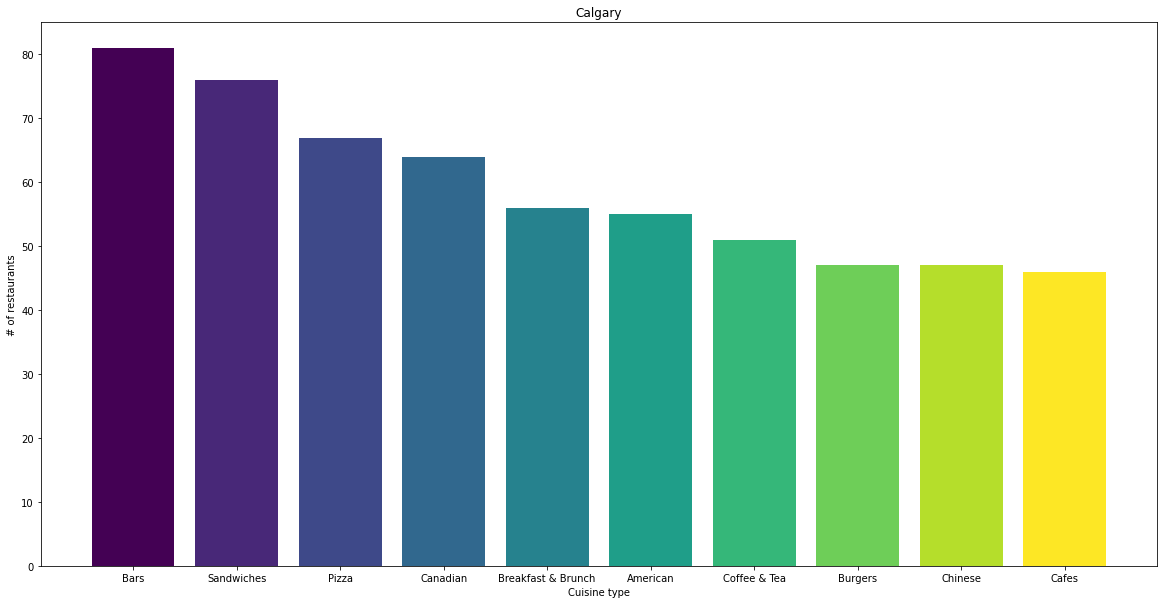

In [47]:
plt.figure(figsize=(20,10))
plt.xlabel("Cuisine type")
plt.ylabel("# of restaurants")
generate_most_common_cuisine_chart(q3_cal_count, 'Calgary',color='viridis')

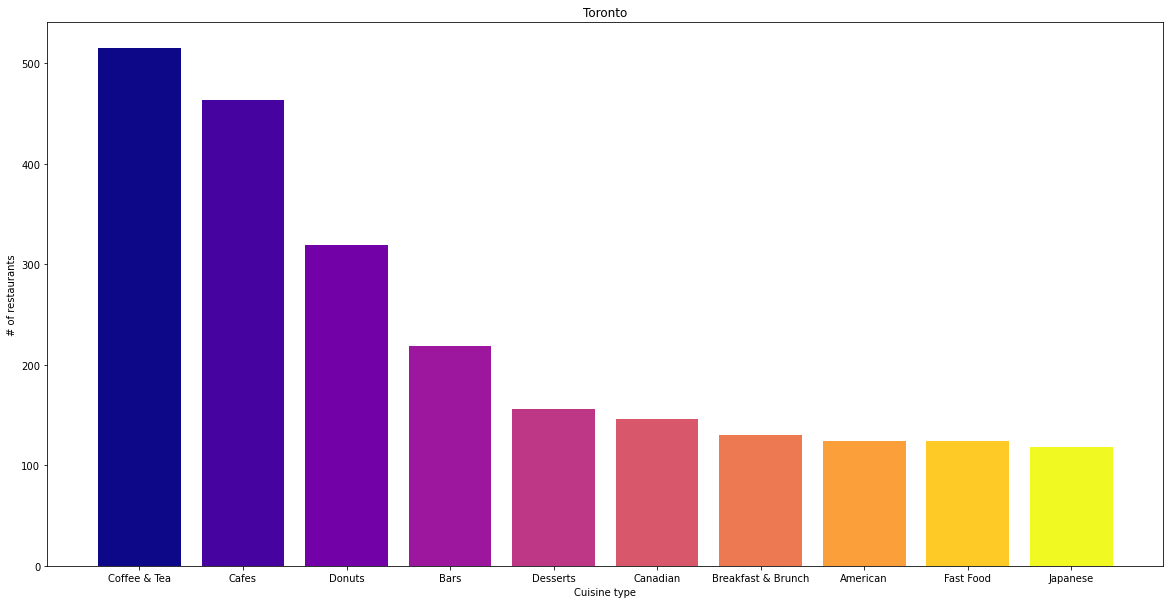

In [48]:
plt.figure(figsize=(20,10))
plt.xlabel("Cuisine type")
plt.ylabel("# of restaurants")
generate_most_common_cuisine_chart(q3_tor_count, 'Toronto',color='plasma')

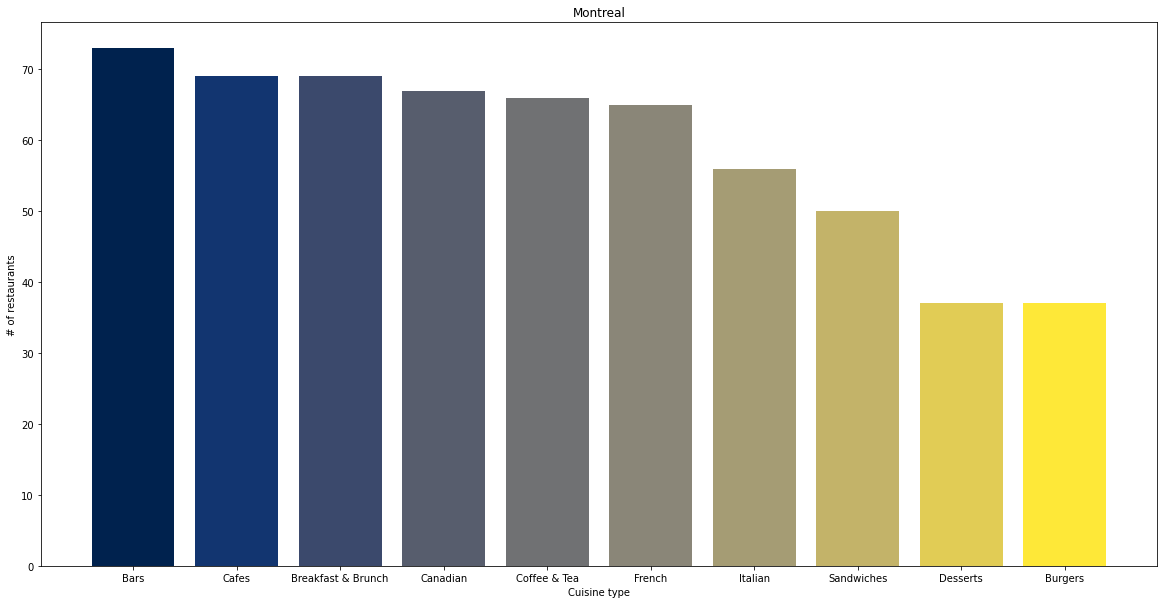

In [49]:
plt.figure(figsize=(20,10))
plt.xlabel("Cuisine type")
plt.ylabel("# of restaurants")
generate_most_common_cuisine_chart(q3_mon_count, 'Montreal',color='cividis')

## Q3 Result:
Bars are the most common type in Calgary and Montreal, While Toronto heavily favors Coffee shops.